Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 landmarks: [[ 32.  65.]
 [ 33.  76.]
 [ 34.  86.]
 [ 34.  97.]]


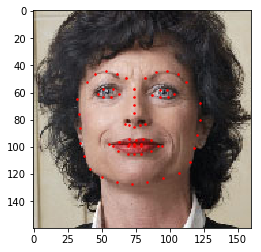

In [22]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

plt.ion()

FACES_PATH = '/Volumes/存储/ye_zexuan/faces/'
landmarks_frame = pd.read_csv(FACES_PATH + 'face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)
print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)
    
plt.figure(num=0)
show_landmarks(io.imread(os.path.join(FACES_PATH, img_name)), landmarks)
plt.show()

## Dataset class
For Dataser class, you should inherient the torch.utils.data.Dataset and override the following method:

- `__len__` so you can call `len(dataset)` to get the size of the dataset.
- `__getitem__` to support indexing, such that `dataset[i]` can be used to get *ith* item.

In the following block, we only read the face_landmarks.csv in `__init__`, but leaving the reading of images to `__getitem__`. It is momory efficient because all the iamges aren't stored in the memory at once but read as required.

In [23]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dateset"""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """Args:
        csv_file (string): Path to the csv file with annotations
        root_dir (string): Directory with all the images
        transform (callable, optional): Optional transform to be applied on a sample
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample



Here we instantiate the `FaceLandmarksDataset` as `face_dataset`, and iterate the sample data through it.

0 (324, 215, 3) (68, 2)


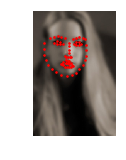

1 (500, 333, 3) (68, 2)


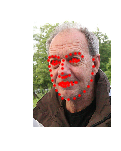

2 (250, 258, 3) (68, 2)


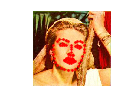

3 (434, 290, 3) (68, 2)


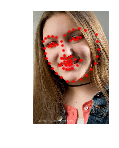

In [74]:
face_dataset = FaceLandmarksDataset(csv_file=FACES_PATH + 'face_landmarks.csv', root_dir=FACES_PATH)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, i + 1)
    ax.axis('off')
    plt.tight_layout()
    show_landmarks(**sample)
    if i is 3:
        plt.show()
        break

## Transforms
In this section we implement the preprocessing part code. which contains three classes: `Rescale`, `RandomCorp` and `ToTensor`.

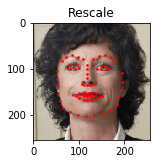

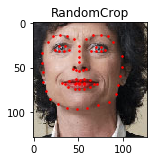

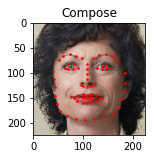

hi


In [65]:
class Rescale(object):
    """Resacle the image to a given size
    
    Args:
    output_size (tuple or int): Desired output size. If tuple, output is
    matched to output_size. If int, smaller of image edges is matched to output_size keeping ratio the same
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        image = transform.resize(image, (new_h, new_w))
        
        landmarks = landmarks * (new_w / w, new_h / h)
        
        return {'image': image, 'landmarks': landmarks}

class RandomCrop(object):
    """Crop randomly the target image
    
    Args: output_size (tuple or int): Desired output size. If int, squard crop is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) is 2
            self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left + new_w]
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}
    

class ToTensor(object):
    """Convert ndarrays to Tensors"""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        image = image.transpose(2, 0, 1)
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
    
    
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()
print('hi')


## Iterating through the dataset

In [75]:
transformed_dataset = FaceLandmarksDataset(csv_file=FACES_PATH + 'face_landmarks.csv', 
                                           root_dir=FACES_PATH,
                                           transform=transforms.Compose([
                                               Rescale((300, 300)),
                                               RandomCrop(99),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    
    if i is 3:
        break

SyntaxError: unexpected EOF while parsing (<ipython-input-75-257e8a0952f4>, line 10)